In [1]:
# Notebook imports

# Used to define paths to files for data import and export
import os
import os.path as op

# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

# Used for preprocessing and splitting of data 
from sklearn.model_selection import train_test_split

# Different models for feature selection
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

# Different models that can be used as classifiers for feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb

# Import our package
from neurasort.bio482.helpers import *

# Remove some useless warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Feature selection notebook

### Part 1 : Loading preprocessed data
In a previous notebook, we already manually selected features that should be left out, either because they were extremely correlated with others or because they just made no sense for prediction. We will load the data of the selected features only.

In [2]:
# Load from csv file
data = pd.read_csv("data_ohe_scaled_constant_free_filled_withsex.csv")

# Leave out Cell_tdTomatoExpressing_True column if it's still there
if 'Cell_tdTomatoExpressing_True' in data.columns:
    data = data.drop(columns=['Cell_tdTomatoExpressing_True'])
data.head()

,Cell_Layer_L2/3,Cell_Layer_L4,Cell_Layer_L5,Mouse_Sex_f,Mouse_Sex_m,Cell_APThreshold_Slope,Cell_Depth,firing_rate,ap_duration,std_vm,fft_low,fft_high,ap_threshold,mean_vm,cell_type
0,1.0,0.0,0.0,0.0,1.0,0.25,0.232394,0.017344,0.102517,0.422821,0.257585,0.297973,0.945152,2.932638,EXC
1,1.0,0.0,0.0,0.0,1.0,0.25,0.445423,0.001067,0.184091,0.338408,0.341667,0.275326,0.431527,0.925393,EXC
2,1.0,0.0,0.0,0.0,1.0,0.25,0.445423,0.000267,0.609091,0.431585,0.433209,0.298462,-0.064111,0.569710,EXC
3,1.0,0.0,0.0,0.0,1.0,0.25,0.445423,0.000000,0.000000,0.381808,0.377532,0.325379,3.584400,1.208404,EXC
4,1.0,0.0,0.0,0.0,1.0,0.25,0.258803,0.000800,0.315152,0.195782,0.158183,0.218183,0.486469,1.406541,EXC


### Part 2 : Splitting in train and test sets

We need train and test sets to be able to do feature selection using the sklearn models.

In [3]:
# Sepatate train and test data 
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

# Get X and y matrices for feature classification
X_train = df_train.drop(columns=["cell_type"])
y_train = df_train["cell_type"]
X_test = df_test.drop(columns=["cell_type"])
y_test = df_test["cell_type"]

# Get feature names
features = X_train.columns

### Part 3 : Feature selection
#### 3.1 Choosing classifier

In [5]:
# Choosing the classifier
classifier = RandomForestClassifier(n_estimators=236, random_state=0, criterion='entropy')
name_classifier = 'RandomForest' # give the name of the classifier to save the file at the end

# Choosing the minimum number of features so consider
min_features_to_select = 1

# List of other possible classifiers :
    # LogisticRegression(max_iter = 500, multi_class="multinomial", random_state=42)
    # RidgeClassifier()
    # SVC(kernel="linear")
    # NuSVC(kernel="linear")
    # DecisionTreeClassifier()
    # ExtraTreeClassifier()

#### 3.2 Recursive feature elimination (RFE) with cross-validation

In [6]:
# Create the RFE object and compute a cross-validated score
rfecv = RFECV(estimator=classifier,
              step=1,
              cv=StratifiedKFold(4, shuffle=True, random_state=42),
              scoring='f1_weighted',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
      estimator=RandomForestClassifier(criterion='entropy', n_estimators=236,
                                       random_state=0),
      scoring='f1_weighted')

Optimal number of features : 12


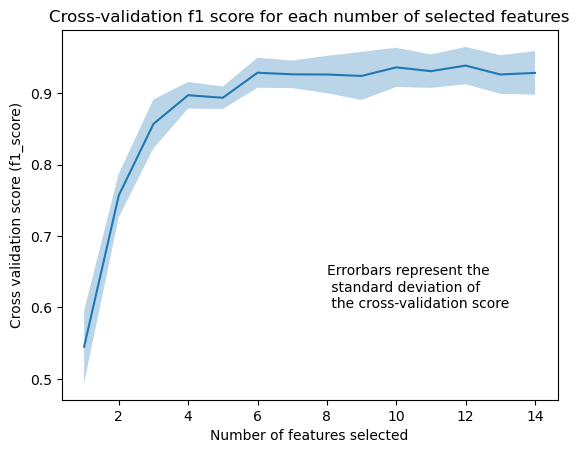

In [7]:
# Optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot cross-validation scores with standard deviation for each number of features 
plt.figure()
sns.lineplot(x=np.arange(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
         y= rfecv.cv_results_["mean_test_score"])
lower_bound = rfecv.cv_results_["mean_test_score"] - rfecv.cv_results_["std_test_score"]
upper_bound = rfecv.cv_results_["mean_test_score"] + rfecv.cv_results_["std_test_score"]
plt.fill_between(np.arange(min_features_to_select, len(rfecv.cv_results_["mean_test_score"])+1), lower_bound, upper_bound, alpha=.3)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1_score)")
plt.title("Cross-validation f1 score for each number of selected features")
plt.text(8, 0.6, "Errorbars represent the \n standard deviation of \n the cross-validation score")
plt.show()

In [8]:
# See feature ranking
df_rfecv = pd.DataFrame(list(zip(features, rfecv.ranking_)), columns =['Feature', 'Rank']).sort_values(by='Rank')
df_rfecv.head(40)

,Feature,Rank
0,Cell_Layer_L2/3,1
3,Mouse_Sex_f,1
4,Mouse_Sex_m,1
5,Cell_APThreshold_Slope,1
6,Cell_Depth,1
7,firing_rate,1
8,ap_duration,1
9,std_vm,1
10,fft_low,1
11,fft_high,1


In [9]:
# Columns selected
features_rfecv = features[rfecv.support_]
features_rfecv

Index(['Cell_Layer_L2/3', 'Mouse_Sex_f', 'Mouse_Sex_m',
       'Cell_APThreshold_Slope', 'Cell_Depth', 'firing_rate', 'ap_duration',
       'std_vm', 'fft_low', 'fft_high', 'ap_threshold', 'mean_vm'],
      dtype='object')

#### 3.3 Sequential Feature Selection
##### 3.3.1 SelectFromModel

First we get an idea of the importance of the features with a logistic regression. Features with the highest absolute coefficient are considered most important

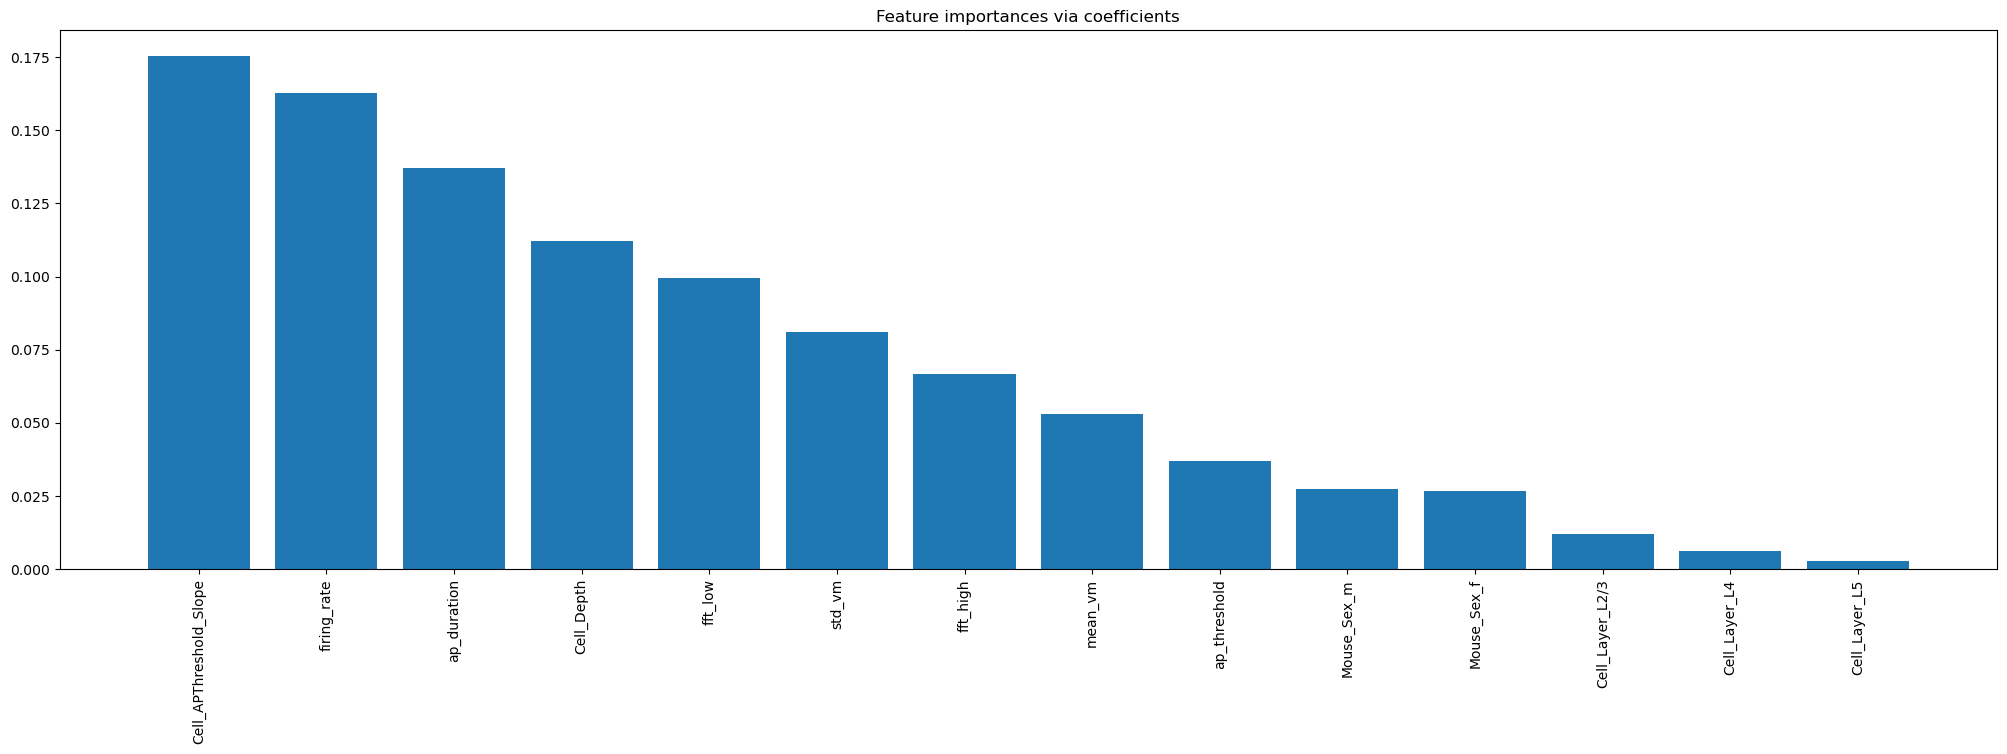

In [12]:
# Choosing the classifier
classifier = RandomForestClassifier(n_estimators=236, random_state=0, criterion='entropy')

# Feature importance from coefficients
importance_fit = classifier.fit(X_train, y_train)
importance = np.abs(importance_fit.feature_importances_)


df_importance = pd.DataFrame(list(zip(features, importance)), columns =['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(25, 7))
plt.bar('Feature', 'Importance', data=df_importance)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

Now we select the features which are most important according to the coefficients using SelectFromModel.

In [14]:
# Choosing the classifier
classifier = RandomForestClassifier(n_estimators=236, random_state=0, criterion='entropy')

threshold = np.sort(importance)[-10] + 0.01
sfm = SelectFromModel(classifier, threshold=threshold).fit(X_train, y_train)

features_sfm = features[sfm.get_support()]
print(f"Features selected by SelectFromModel: {features_sfm}")

Features selected by SelectFromModel: Index(['Cell_APThreshold_Slope', 'Cell_Depth', 'firing_rate', 'ap_duration',
       'std_vm', 'fft_low', 'fft_high', 'mean_vm'],
      dtype='object')


##### 3.3.2 SequentialFeatureSelection

In [23]:
# Forward sequential feature selection
sfs_forward = SequentialFeatureSelector(classifier, n_features_to_select=12, direction="forward").fit(X_train, y_train)

In [24]:
# Backwards sequential feature selection
sfs_backward = SequentialFeatureSelector(classifier, n_features_to_select=12, direction="backward").fit(X_train, y_train)

In [25]:
# Selected features
features_sfs_forward = features[sfs_forward.get_support()]
print("Features selected by forward sequential selection:\n " f"{features_sfs_forward}")

#print('------')

features_sfs_backward = features[sfs_backward.get_support()]
print("Features selected by backward sequential selection:\n " f"{features_sfs_backward}")

Features selected by forward sequential selection:
 Index(['Cell_Layer_L4', 'Cell_Layer_L5', 'Mouse_Sex_f', 'Mouse_Sex_m',
       'Cell_APThreshold_Slope', 'Cell_Depth', 'firing_rate', 'ap_duration',
       'std_vm', 'fft_high', 'ap_threshold', 'mean_vm'],
      dtype='object')
Features selected by backward sequential selection:
 Index(['Cell_Layer_L2/3', 'Cell_Layer_L5', 'Mouse_Sex_f', 'Mouse_Sex_m',
       'Cell_APThreshold_Slope', 'Cell_Depth', 'firing_rate', 'ap_duration',
       'std_vm', 'fft_low', 'fft_high', 'ap_threshold'],
      dtype='object')


### Part 4 : Discussion

In [26]:
# Get all the selected features for each method

# Recursive feature elimination wants 12 features, so we keep top 12
features_rfecv = df_rfecv.iloc[0:12]["Feature"].values
# Select from model
features_sfm = np.array(features_sfm)
# Forward sequential selection
features_sfs_forward = np.array(features_sfs_forward)
# Backward sequential selection
features_sfs_backward = np.array(features_sfs_backward)


In [27]:
# Get dataframe to see which features are selected by which method

# Convert list of features selected in pd.Series
features_rfecv = pd.Series(features_rfecv)
features_sfm = pd.Series(features_sfm)
features_sfs_forward = pd.Series(features_sfs_forward)
features_sfs_backward = pd.Series(features_sfs_backward)

# List of all unique features selected for all methods
features_all = pd.Series(pd.concat([features_rfecv, features_sfm, features_sfs_forward]).unique())  # features_sfs_backward

# Test for each method if the given feature is selected for each feature in features_all
test_rfecv = features_all.isin(features_rfecv)
test_sfm = features_all.isin(features_sfm)
test_sfs_forward = features_all.isin(features_sfs_forward)
test_sfs_backward = features_all.isin(features_sfs_backward)

# Construct dataframe
df_comparison = pd.DataFrame(list(zip(features_all, test_rfecv, test_sfm, test_sfs_forward, test_sfs_backward)), # test_sfs_backward
                             columns =['Feature', 'rfecv', 'sfm', 'sfs_fwd', 'sfs_bkd']) # 'sfs_bkd'

# Set feature column as dataframe index
df_comparison = df_comparison.set_index("Feature")

# Add column with number of True
df_comparison['Number'] = df_comparison.replace({False:0, True:1}).sum(axis=1)

# Sort values
df_comparison = df_comparison.sort_values(by='Number', ascending=False) \
                             .replace({False:"", True:"X"})

df_comparison

,rfecv,sfm,sfs_fwd,sfs_bkd,Number
Feature,,,,,
Cell_APThreshold_Slope,X,X,X,X,4
Cell_Depth,X,X,X,X,4
firing_rate,X,X,X,X,4
ap_duration,X,X,X,X,4
std_vm,X,X,X,X,4
fft_high,X,X,X,X,4
Mouse_Sex_f,X,,X,X,3
Mouse_Sex_m,X,,X,X,3
fft_low,X,X,,X,3


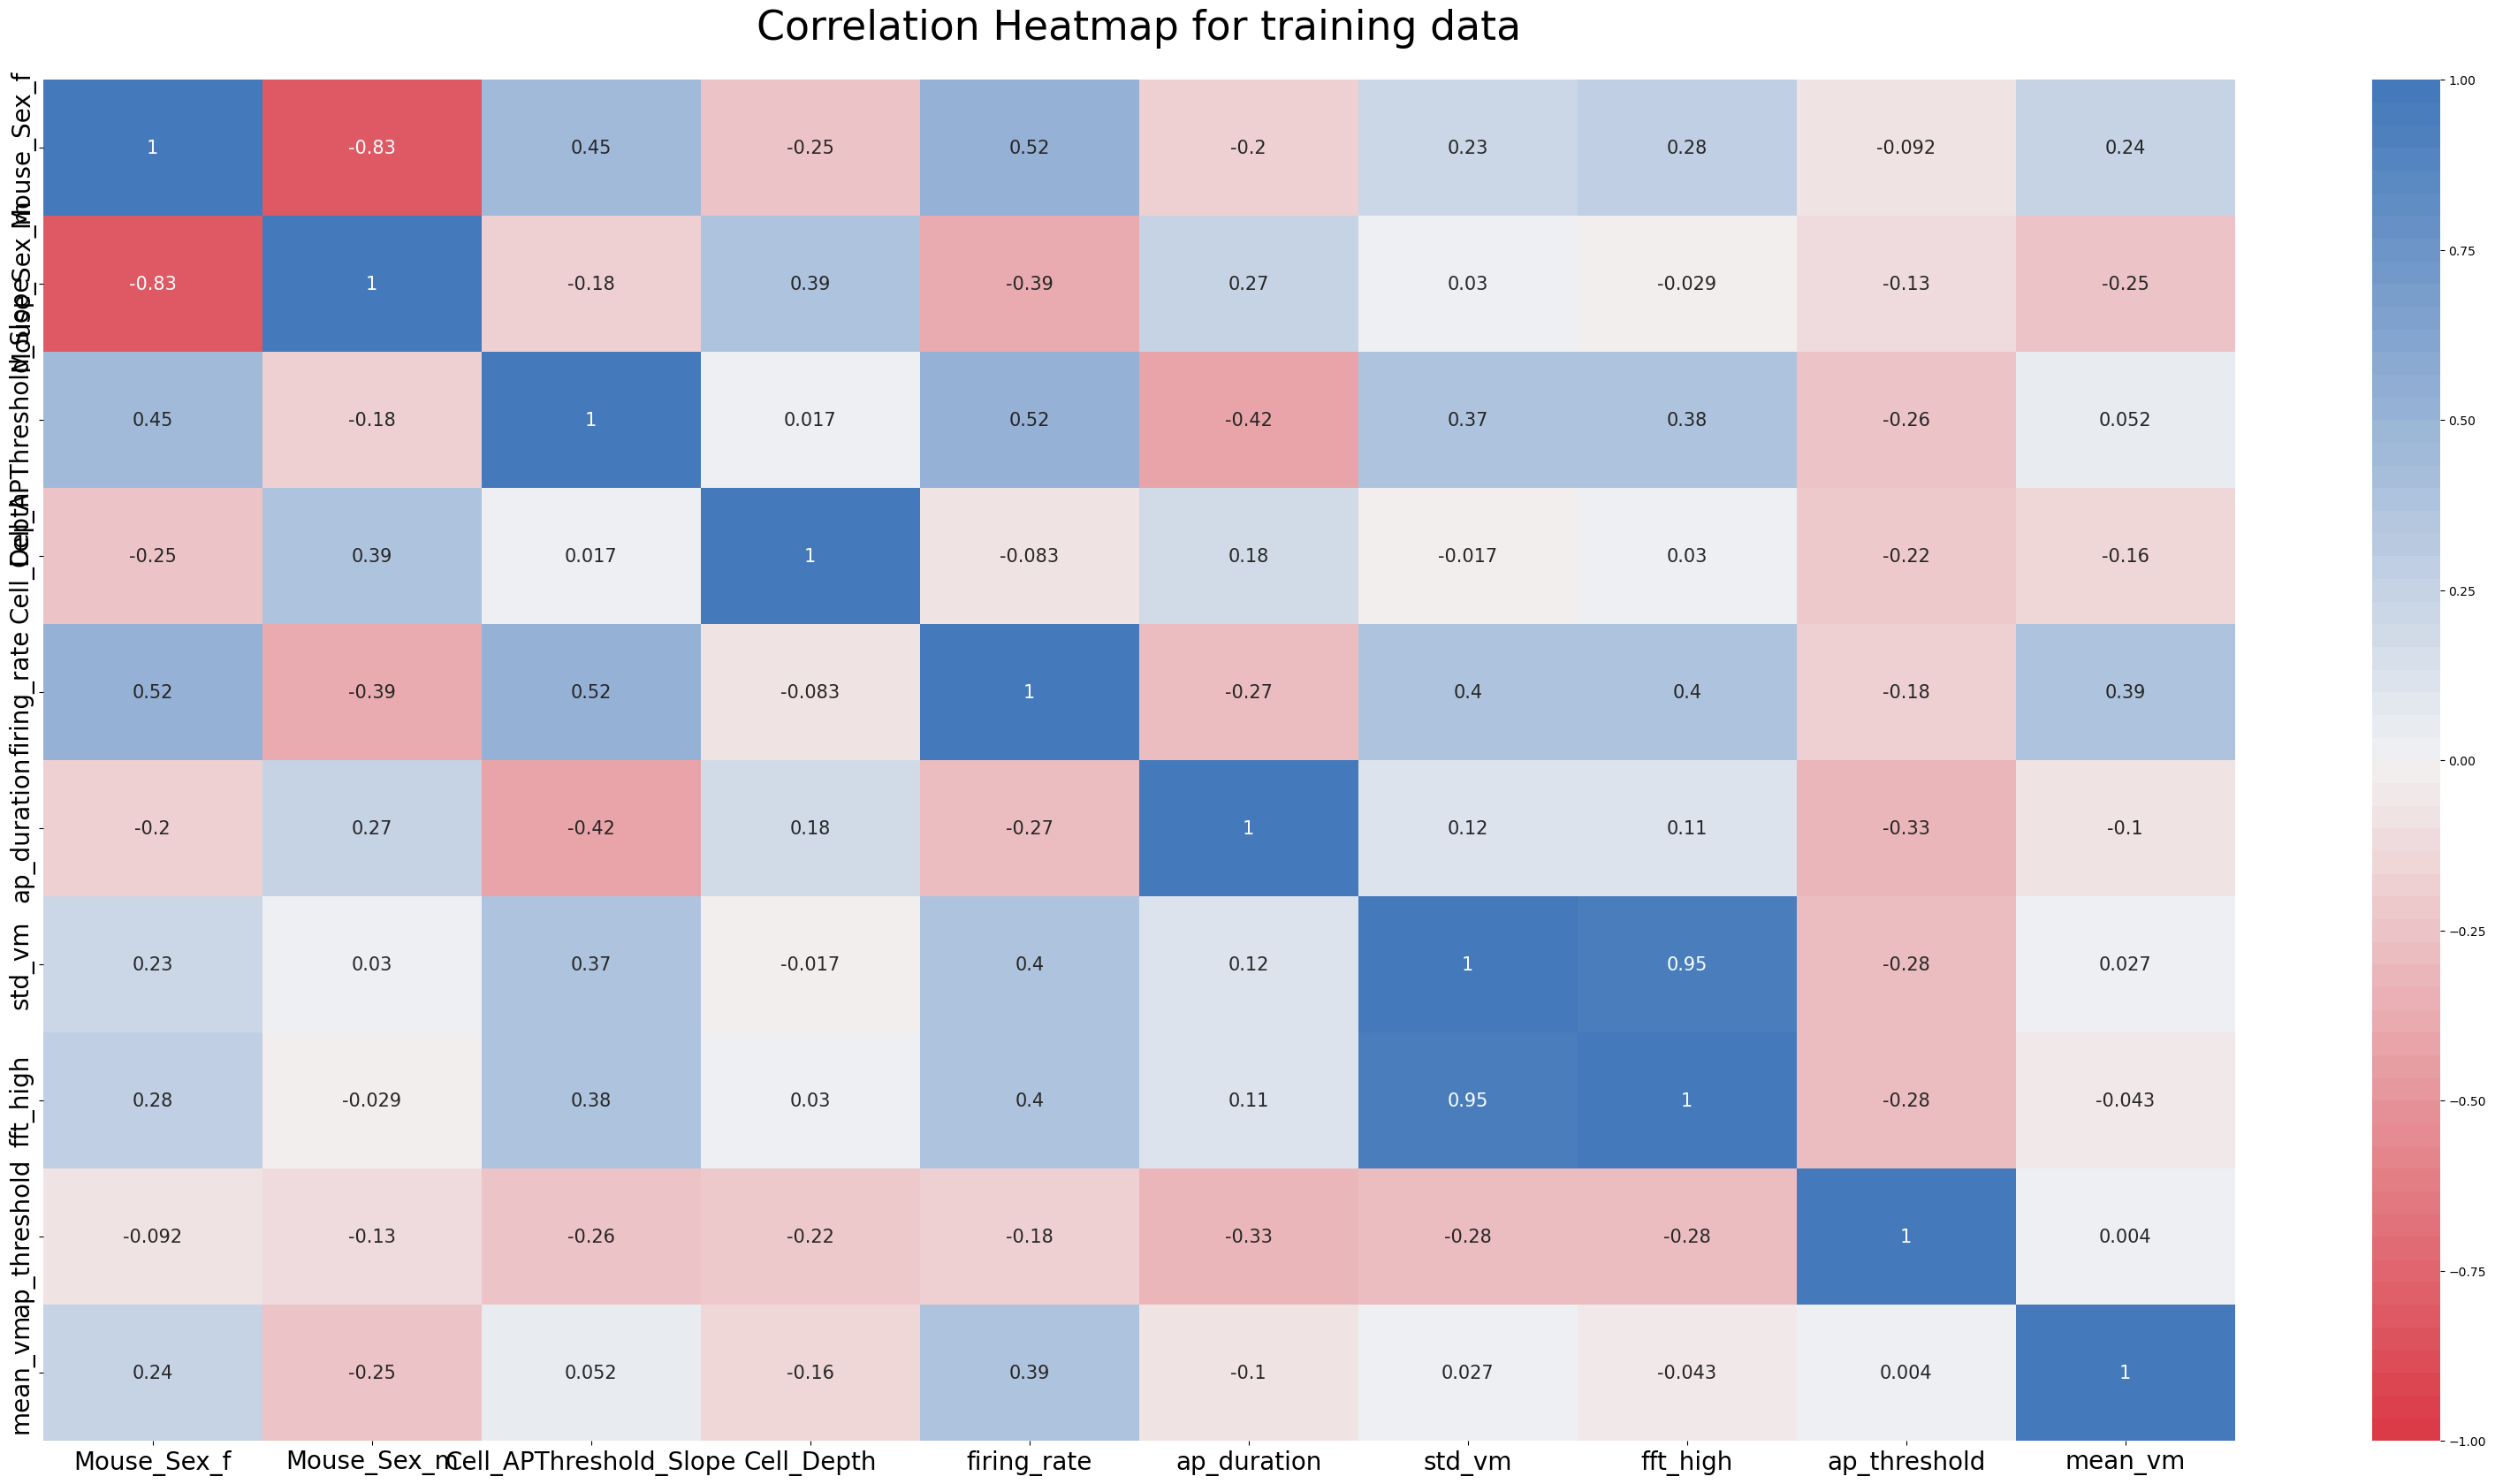

In [21]:
# Heatmap of correlation between features we keep
# Keep the chosen features
features_toKeep = features_sfs_forward # can be changed, here the features selected by forward sequential selection are kept because te/hey are amongst most chosen across all methods
# Get the X_train matrix with only the features we keep
X_selection_train = X_train[features_toKeep]
# Plot correlation heatmap
plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(round(X_selection_train.corr(),3), annot=True,  vmin=-1, vmax=1, cmap = sns.diverging_palette(10,250, n=60), annot_kws={"fontsize":15})
heatmap.set_title('Correlation Heatmap for training data', fontdict={'fontsize':33}, pad=33)
plt.tick_params(axis='both', labelsize=20)

We see that fft_low and Cell_APThreshold_Slope are very positively correlated, as indicated by their coefficient of 0.72. Let's try and visualize that.

In [22]:
# Print unique values of one Cell_APThreshold variable
print("Unique values for the Cell_APThreshold variable :", np.sort(X_selection_train["Cell_APThreshold_Slope"].unique()))

# Print histogram of the fft_low variable
plt.figure(figsize=(20, 10))
plt.hist(X_selection_train["fft_low"], bins=100)
plt.xlabel("fft_low")
plt.ylabel("Count")
plt.title("Histogram of fft_low")
plt.show()

Unique values for the Cell_APThreshold variable : [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


KeyError: 'fft_low'

<Figure size 2000x1000 with 0 Axes>

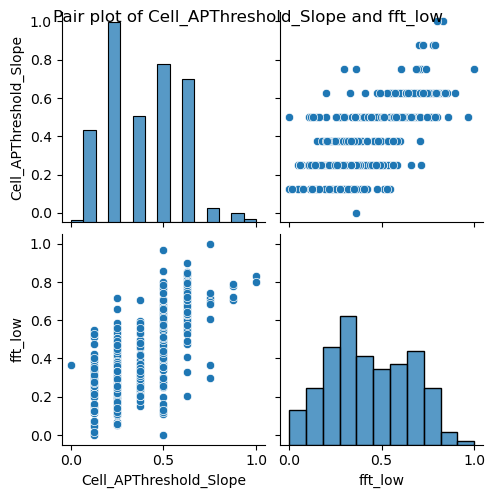

In [41]:
# Look at their interplay using seaborn
# Pair plot
sns.pairplot(X_selection_train[["Cell_APThreshold_Slope", "fft_low"]])
plt.suptitle("Pair plot of Cell_APThreshold_Slope and fft_low")
plt.show()

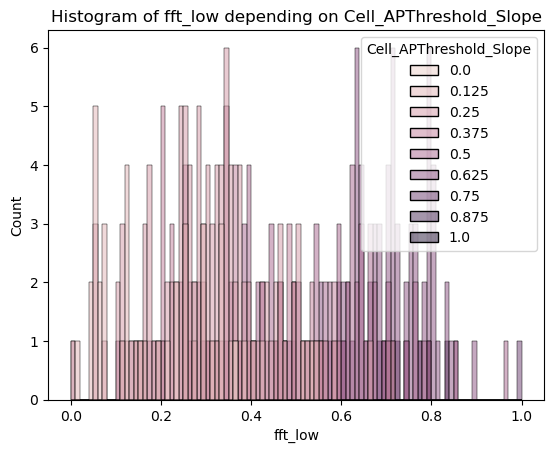

In [42]:
# Histogram with hue
sns.histplot(data=X_selection_train, x="fft_low", hue="Cell_APThreshold_Slope", bins=100)
plt.title("Histogram of fft_low depending on Cell_APThreshold_Slope")
plt.show()